In [13]:
import pandas as pd
import numpy as np
import Memory as mm
import time
import collections
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
from sklearn.tree import _tree
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
import pydotplus
from sklearn.externals.six import StringIO 
from IPython.display import Image

In [19]:
# 读取标签为GB的大宽表
# GB数据比N数据多了一列month，是用来做月份滚动建模用的
big_sheet_GB = pd.read_csv('garbage_data/入模数据GB.csv')
big_sheet_GB = mm.reduce_mem_usage(big_sheet_GB)

Reduce Memory Usage Function Reports:
Memory usage of dataframe is 2030.39 MB
Memory usage after optimization is: 658.63 MB
Decreased by 67.6%
 


In [24]:
# 这一列里有10537个数据是空值，也就是没有打月份标签，是因为这些数据是2017年的
# 因为数据量过少，本身影响微乎其微
big_sheet_GB['month'].isnull().sum()

10537

In [20]:
# 读取标签为N的大宽表
# N数据是我们做完预测后发给银行的
big_sheet_N = pd.read_csv('garbage_data/入模数据N.csv')
big_sheet_N = mm.reduce_mem_usage(big_sheet_N)

Reduce Memory Usage Function Reports:
Memory usage of dataframe is 925.22 MB
Memory usage after optimization is: 292.65 MB
Decreased by 68.4%
 


In [53]:
# 衍生比例数据的时候，部分比例计算为0/0，或nan/0，或0/nan造成无穷值
# 用空值替换无穷
big_sheet_GB = big_sheet_GB.replace([np.inf,-np.inf],np.nan)
big_sheet_N = big_sheet_N.replace([np.inf,-np.inf],np.nan)

In [9]:
# 读取外部数据，用于分群建模用
outside_data1 = pd.read_csv('outside_data/eternal_data_dys.csv',encoding='GBK')
outside_data1 = mm.reduce_mem_usage(outside_data1)

outside_data2 = pd.read_csv('outside_data/eternal_data_hy.csv',encoding='GBK')
outside_data2 = mm.reduce_mem_usage(outside_data2)

outside_data3 = pd.read_csv('outside_data/eternal_data_yjy.csv',encoding='GBK')
outside_data3 = mm.reduce_mem_usage(outside_data3)

outside_data = pd.merge(outside_data1,outside_data2,on='id',how='inner')
outside_data = pd.merge(outside_data,outside_data3,on='id',how='inner')

del outside_data1,outside_data2,outside_data3

Reduce Memory Usage Function Reports:
Memory usage of dataframe is 411.54 MB
Memory usage after optimization is: 73.27 MB
Decreased by 82.2%
 


In [10]:
# 这三个新数据来源是后来银行又给到的新数据来源，你们可以选择是否drop掉，来探索一下前后分群效果是否有提升
# 我们的选择结果是暂时drop掉，因为本身数据量很小，加入这三个特征后，分群的子群会有样本量很小的子群，进而造成过拟合
outside_data.drop(['公积金数据','养老金数据','资产表数据'],axis=1,inplace=True)

## 树分群Class

In [17]:
class TreeSplit():
    
    def __init__(self,df,depths,min_leaf):
        
        self.df = df.copy()
        self.depths = depths
        self.min_leaf = min_leaf

    def splitGB_NR(self):
        
        cond1 = self.df['bad']=='N'
        cond2 = self.df['bad']=='R'
        cond3 = self.df['bad']=='G'
        cond4 = self.df['bad']=='B'

        cond_1 = cond3|cond4
        cond_2 = cond1

        self.df_NR = self.df.loc[cond_2].reset_index(drop=True)
        self.df_GB = self.df.loc[cond_1].reset_index(drop=True)
        
        self.df_GB['bad'].replace({'R':'B'},inplace=True)

        return self.df_GB,self.df_NR
    
    def XY_split(self):
        
        self.X_GB = self.df_GB.drop(['id','bad'],axis=1)
        self.y_GB = self.df_GB['bad']
        
        self.X_NR = self.df_NR.drop(['id','bad'],axis=1)
        
    def FitTree(self):
        
        print('执行分群')
        start = time.time()
        tree_clf = DecisionTreeClassifier(random_state=2,max_depth=self.depths,
                                          min_samples_leaf=self.min_leaf)
        
        tree_clf.fit(self.X_GB,self.y_GB)
        self.tree_clf = tree_clf
        
        self.SubsetID_NR = tree_clf.apply(self.X_NR)
        
        self.grandson_split_ID_NR = np.unique(self.SubsetID_NR)
        end = time.time()
        print('分群结束, 用时{}秒'.format(np.round(end-start,2)))
        
    def Visualize(self):
        
        self.dot_data = StringIO()
        tree.export_graphviz(self.tree_clf, 
                             out_file=self.dot_data,
                             feature_names=self.X_GB.columns,
                             filled=True, 
                             rounded=True, 
                             special_characters=True)

        self.graph = pydotplus.graph_from_dot_data(self.dot_data.getvalue()) 
        
        
    def SubSetsRecord(self):
        
        print('记录叶节点信息')
        start = time.time()
        dec_path = self.tree_clf.decision_path(self.X_GB)
        self.all_nodes = collections.defaultdict(list)

        for d, dec in enumerate(dec_path):
            for i in range(self.tree_clf.tree_.node_count):
                if dec.toarray()[0][i] == 1:
                    self.all_nodes[i].append(d) 
        
        self.NR_nodes = {}
        for i in self.grandson_split_ID_NR:
            self.NR_nodes[i] = np.where(self.SubsetID_NR==i)
        
        self.end_nodes = {}
        for i in self.grandson_split_ID_NR:
            self.end_nodes[i] = self.all_nodes[i]
                
        end = time.time()
        print('叶节点信息记录完毕, 用时{}秒'.format(np.round(end-start,2)))
     
    # 这一part后来没有实际用到，因为提取规则输出的字符串没法用，留在这里不影响代码运行，后续觉得有改进空间的话供你们参考
    def ExtractRules(self):
        
        tree_ = self.tree_clf.tree_
        self.feature_name = [self.feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
                             for i in tree_.feature]

        #print("def tree({}):".format(", ".join(feature_names)))

        def recurse(node, depth):
            indent = "  " * depth
            if tree_.feature[node] != _tree.TREE_UNDEFINED:
                self.split_name = self.feature_name[node]
                self.threshold = tree_.threshold[node]

#                 print('name',name)
#                 print('threshold',threshold)

                print("{}if {} <= {}:".format(indent, self.split_name, self.threshold))
                recurse(tree_.children_left[node], depth + 1)
                print("{}else:  # if {} > {}".format(indent, self.split_name, self.threshold))
                recurse(tree_.children_right[node], depth + 1)
            else:
                print("{}return {}".format(indent, tree_.value[node]))

        recurse(0, 1)
    
    
    def Ignite(self):
        
        self.splitGB_NR()
        self.XY_split()
        self.FitTree()
        self.Visualize()
        self.SubSetsRecord()

**执行树分群**

In [18]:
outside_data_tree_dict = {}
# 如果想分更多的群或者更小的群，可以改变list里的元素
# list里的元素代表树的深度，这里代表分别用深度为3，4的树分群
for i in [3,4]:
    outside_data_tree = TreeSplit(outside_data,i,100000)  #叶节点数量设置
    outside_data_tree.Ignite()
    outside_data_tree_dict[i] = outside_data_tree
outside_data_tree3 = outside_data_tree_dict[3]
outside_data_tree4 = outside_data_tree_dict[4]
del outside_data_tree_dict,outside_data_tree

执行分群
分群结束, 用时1.87秒
记录叶节点信息
叶节点信息记录完毕, 用时115.03秒
执行分群
分群结束, 用时1.99秒
记录叶节点信息
叶节点信息记录完毕, 用时108.89秒


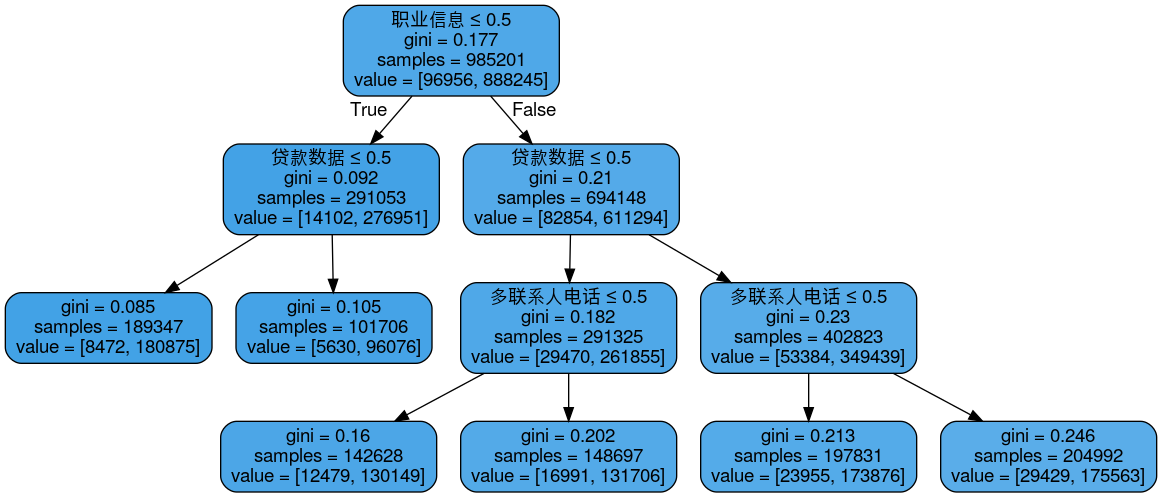

In [31]:
# 可视化分群规则
Image(outside_data_tree3.graph.create_png())

## Def LGBM

In [125]:
# 不分群时采用的参数
lgbm_clf0 = lgb.LGBMClassifier()

# 树深度为3时采用的参数
lgbm_clf1 = lgb.LGBMClassifier(n_estimators=40,max_depth=5,lambda_l1=0.5,lambda_l2=5)

# 树深度为更多时采用的参数
lgbm_clf2 = lgb.LGBMClassifier(n_estimators=14,max_depth=5,lambda_l1=0.5,lambda_l2=6)

# 由于时间原因，以上参数组合都没有对每个子群【分别】进行调参；
# 以及有很多其他参数可以调整，比如max_bin,colsample_bytree,feature_fraction
# 后续可采用贝叶斯调参的外部api进行调参，不过可能耗时较长性价比未必高，建议优先级排序最后考虑

def LGBM(lgbm_clf,X_GB,y_GB,X_N_df,i,if_month=1,month_pairs=None):
    
    start = time.time()
    sk = StratifiedKFold(n_splits=5, shuffle=True)
    
    print('进行模型训练前准备阶段')
    
    # 采用滚动月份建模方式
    if if_month==1:
        
        # LGBM 可以不用做归一化处理,归一化前后不影响模型表现
        scaler = MinMaxScaler()
        X_GB.iloc[:,:-1] = scaler.fit_transform(X_GB.iloc[:,:-1])
        
        cond = X_GB['month'].isin(month_pairs[i]['train'])
        X_train = X_GB.loc[cond].drop('month',axis=1).values
        Y_train = y_GB.loc[cond]
        
        cond = X_GB['month'].isin(month_pairs[i]['test'])
        X_test = X_GB.loc[cond].drop('month',axis=1).values
        Y_test = y_GB.loc[cond] 
        
    # 一般建模方式
    else:
        
        scaler = MinMaxScaler()
        X_GB_scaled = scaler.fit_transform(X_GB.drop('month',axis=1))
        X_train,X_test,Y_train,Y_test = train_test_split(X_GB_scaled,y_GB,test_size=0.3,random_state=2)

    scaler = MinMaxScaler()    
    X_N_scaled = scaler.fit_transform(X_N_df.drop(['id','bad'],axis=1))
    
    train_good = sum(Y_train)
    train_bad = len(Y_train)-train_good

    test_good = sum(Y_test)
    test_bad = len(Y_test)-test_good
    
    total_good = train_good + test_good  
    total_bad = train_bad + test_bad  
        
    preds = []
    preds_train = []   
    
    N_preds = []
    
    ftimps = []
    
    print('开始训练LGBM模型{}'.format(i))
    
    # 采用Kaggle高票kernel中5折交叉验证+及时做预测的方式，一定程度防止过拟合
    for train_index, val_index in sk.split(X_train, Y_train):

        x_train, x_val = X_train[train_index,:], X_train[val_index,:]
        y_train, y_val = Y_train.iloc[train_index], Y_train.iloc[val_index]

        lgbm_clf.fit(x_train, y_train, eval_set=[(x_val, y_val)],early_stopping_rounds=20)

        preds.append(lgbm_clf.predict_proba(X_test)[:,1])
        preds_train.append(lgbm_clf.predict_proba(X_train)[:,1])
        
        N_preds.append(lgbm_clf.predict_proba(X_N_scaled)[:,1])
        
        ftimps.append(lgbm_clf.feature_importances_)

    pred = np.mean(preds,axis=0)
    pred_train = np.mean(preds_train,axis=0)
        
    N_pred = np.mean(N_preds,axis=0)
    
    ftimp = np.mean(ftimps,axis=0)
    
    auc = roc_auc_score(Y_test,pred)
    auc_train = roc_auc_score(Y_train,pred_train)
    
    fpr,tpr,thresholds= roc_curve(Y_test,pred)
    ks = max(tpr-fpr)
    GB_thres = thresholds[np.argmax(tpr-fpr)]
    
    fpr,tpr,thresholds= roc_curve(Y_train,pred_train)
    ks_train = max(tpr-fpr)
 
    N_pred_df = pd.DataFrame({'id':X_N_df['id'],'pred_good_prob':N_pred})
    N_pred_df['split'] = i
    
    end = time.time()
    print('LGBM模型{}训练完成, 耗时{}秒'.format(i,np.round(end-start,2)))
    print()
    
    return_dict = {'test_auc':auc,'test_ks':ks,'test_good':test_good,'test_bad':test_bad,
                   'train_auc':auc_train,'train_ks':ks_train,'train_good':train_good,'train_bad':train_bad,
                   'total_good':total_good,'total_bad':total_bad,'GB_thres':GB_thres,
                   'train_test_auc_gap':auc_train-auc,'train_test_ks_gap':ks_train-ks}
    
    
    return return_dict,Y_test,pred,Y_train,pred_train,train_good,train_bad,ftimp,N_pred_df,lgbm_clf

### 非月份滚动方式分群建模

In [115]:
# 不分群结果：
X_GB = big_sheet_GB.iloc[end_nodes[i],:].drop(['id','bad'],axis=1)
Y_GB = big_sheet_GB['bad'].iloc[end_nodes[i]].replace({'G':1,'B':0}) 
lgbm_mother = LGBM(lgbm_clf0,X_GB,Y_GB,big_sheet_N,'mother',if_month=0)

进行模型训练前准备阶段
开始训练LGBM模型mother
[1]	valid_0's binary_logloss: 0.400022
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.391761
[3]	valid_0's binary_logloss: 0.385429
[4]	valid_0's binary_logloss: 0.380346
[5]	valid_0's binary_logloss: 0.376074
[6]	valid_0's binary_logloss: 0.372445
[7]	valid_0's binary_logloss: 0.369389
[8]	valid_0's binary_logloss: 0.367002
[9]	valid_0's binary_logloss: 0.364698
[10]	valid_0's binary_logloss: 0.362347
[11]	valid_0's binary_logloss: 0.360557
[12]	valid_0's binary_logloss: 0.358889
[13]	valid_0's binary_logloss: 0.357441
[14]	valid_0's binary_logloss: 0.356204
[15]	valid_0's binary_logloss: 0.35497
[16]	valid_0's binary_logloss: 0.353688
[17]	valid_0's binary_logloss: 0.35256
[18]	valid_0's binary_logloss: 0.351672
[19]	valid_0's binary_logloss: 0.350728
[20]	valid_0's binary_logloss: 0.349861
[21]	valid_0's binary_logloss: 0.349159
[22]	valid_0's binary_logloss: 0.348522
[23]	valid_0's binary_logloss: 0.347796
[

[1]	valid_0's binary_logloss: 0.399961
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.391756
[3]	valid_0's binary_logloss: 0.385326
[4]	valid_0's binary_logloss: 0.380285
[5]	valid_0's binary_logloss: 0.376149
[6]	valid_0's binary_logloss: 0.372669
[7]	valid_0's binary_logloss: 0.36985
[8]	valid_0's binary_logloss: 0.367286
[9]	valid_0's binary_logloss: 0.365179
[10]	valid_0's binary_logloss: 0.363155
[11]	valid_0's binary_logloss: 0.361342
[12]	valid_0's binary_logloss: 0.359826
[13]	valid_0's binary_logloss: 0.358475
[14]	valid_0's binary_logloss: 0.3572
[15]	valid_0's binary_logloss: 0.356038
[16]	valid_0's binary_logloss: 0.355026
[17]	valid_0's binary_logloss: 0.354094
[18]	valid_0's binary_logloss: 0.352924
[19]	valid_0's binary_logloss: 0.351951
[20]	valid_0's binary_logloss: 0.351085
[21]	valid_0's binary_logloss: 0.350225
[22]	valid_0's binary_logloss: 0.349535
[23]	valid_0's binary_logloss: 0.348744
[24]	valid_0's binary_logloss: 

[1]	valid_0's binary_logloss: 0.399456
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.391256
[3]	valid_0's binary_logloss: 0.384898
[4]	valid_0's binary_logloss: 0.379832
[5]	valid_0's binary_logloss: 0.37563
[6]	valid_0's binary_logloss: 0.372032
[7]	valid_0's binary_logloss: 0.368887
[8]	valid_0's binary_logloss: 0.366464
[9]	valid_0's binary_logloss: 0.364146
[10]	valid_0's binary_logloss: 0.36218
[11]	valid_0's binary_logloss: 0.360497
[12]	valid_0's binary_logloss: 0.358846
[13]	valid_0's binary_logloss: 0.357209
[14]	valid_0's binary_logloss: 0.355785
[15]	valid_0's binary_logloss: 0.354643
[16]	valid_0's binary_logloss: 0.353564
[17]	valid_0's binary_logloss: 0.352642
[18]	valid_0's binary_logloss: 0.351728
[19]	valid_0's binary_logloss: 0.350779
[20]	valid_0's binary_logloss: 0.349875
[21]	valid_0's binary_logloss: 0.349004
[22]	valid_0's binary_logloss: 0.348357
[23]	valid_0's binary_logloss: 0.347627
[24]	valid_0's binary_logloss:

In [54]:
# 树深度为3分群结果
end_nodes = outside_data_tree3.end_nodes
nodes_id = end_nodes.keys()
N_nodes = outside_data_tree3.NR_nodes

lgbm3_return_dict={}

for i in nodes_id:
    X_GB = big_sheet_GB.iloc[end_nodes[i],:].drop(['id','bad'],axis=1)
    Y_GB = big_sheet_GB['bad'].iloc[end_nodes[i]].replace({'G':1,'B':0}) 
    X_N = big_sheet_N.iloc[N_nodes[i]]
    
    lgbm3_return_dict[i] = LGBM(lgbm_clf1,X_GB,Y_GB,X_N,i,if_month=0)

进行模型训练前准备阶段


/home/mwei/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:375: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/mwei/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:376: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/home/mwei/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:375: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/mwei/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:376: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


开始训练LGBM模型2
[1]	valid_0's binary_logloss: 0.1784
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.175748
[3]	valid_0's binary_logloss: 0.173675
[4]	valid_0's binary_logloss: 0.171892
[5]	valid_0's binary_logloss: 0.170343
[6]	valid_0's binary_logloss: 0.169084
[7]	valid_0's binary_logloss: 0.168055
[8]	valid_0's binary_logloss: 0.167066
[9]	valid_0's binary_logloss: 0.16609
[10]	valid_0's binary_logloss: 0.16538
[11]	valid_0's binary_logloss: 0.1647
[12]	valid_0's binary_logloss: 0.16406
[13]	valid_0's binary_logloss: 0.163552
[14]	valid_0's binary_logloss: 0.16304
[15]	valid_0's binary_logloss: 0.162542
[16]	valid_0's binary_logloss: 0.162225
[17]	valid_0's binary_logloss: 0.161919
[18]	valid_0's binary_logloss: 0.161572
[19]	valid_0's binary_logloss: 0.161206
[20]	valid_0's binary_logloss: 0.160786
[21]	valid_0's binary_logloss: 0.160557
[22]	valid_0's binary_logloss: 0.160278
[23]	valid_0's binary_logloss: 0.160111
[24]	valid_0's binary_lo

[33]	valid_0's binary_logloss: 0.159646
[34]	valid_0's binary_logloss: 0.159533
[35]	valid_0's binary_logloss: 0.159394
[36]	valid_0's binary_logloss: 0.159294
[37]	valid_0's binary_logloss: 0.159244
[38]	valid_0's binary_logloss: 0.159174
[39]	valid_0's binary_logloss: 0.159073
[40]	valid_0's binary_logloss: 0.158932
Did not meet early stopping. Best iteration is:
[40]	valid_0's binary_logloss: 0.158932
LGBM模型2训练完成, 耗时40.08秒

进行模型训练前准备阶段
开始训练LGBM模型3
[1]	valid_0's binary_logloss: 0.207216
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.201603
[3]	valid_0's binary_logloss: 0.19757
[4]	valid_0's binary_logloss: 0.194172
[5]	valid_0's binary_logloss: 0.191483
[6]	valid_0's binary_logloss: 0.189136
[7]	valid_0's binary_logloss: 0.187121
[8]	valid_0's binary_logloss: 0.185423
[9]	valid_0's binary_logloss: 0.183938
[10]	valid_0's binary_logloss: 0.182564
[11]	valid_0's binary_logloss: 0.181422
[12]	valid_0's binary_logloss: 0.180371
[13]	valid_0's

[22]	valid_0's binary_logloss: 0.175996
[23]	valid_0's binary_logloss: 0.175534
[24]	valid_0's binary_logloss: 0.175224
[25]	valid_0's binary_logloss: 0.174892
[26]	valid_0's binary_logloss: 0.174602
[27]	valid_0's binary_logloss: 0.174345
[28]	valid_0's binary_logloss: 0.174142
[29]	valid_0's binary_logloss: 0.173855
[30]	valid_0's binary_logloss: 0.173703
[31]	valid_0's binary_logloss: 0.173552
[32]	valid_0's binary_logloss: 0.173353
[33]	valid_0's binary_logloss: 0.173167
[34]	valid_0's binary_logloss: 0.173039
[35]	valid_0's binary_logloss: 0.172791
[36]	valid_0's binary_logloss: 0.17267
[37]	valid_0's binary_logloss: 0.172388
[38]	valid_0's binary_logloss: 0.17224
[39]	valid_0's binary_logloss: 0.17209
[40]	valid_0's binary_logloss: 0.17208
Did not meet early stopping. Best iteration is:
[40]	valid_0's binary_logloss: 0.17208
LGBM模型3训练完成, 耗时31.43秒

进行模型训练前准备阶段


/home/mwei/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:375: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/mwei/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:376: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/home/mwei/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:375: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/mwei/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:376: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


开始训练LGBM模型6
[1]	valid_0's binary_logloss: 0.286937
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.280508
[3]	valid_0's binary_logloss: 0.275427
[4]	valid_0's binary_logloss: 0.271375
[5]	valid_0's binary_logloss: 0.268263
[6]	valid_0's binary_logloss: 0.265243
[7]	valid_0's binary_logloss: 0.26285
[8]	valid_0's binary_logloss: 0.260799
[9]	valid_0's binary_logloss: 0.258974
[10]	valid_0's binary_logloss: 0.257416
[11]	valid_0's binary_logloss: 0.256112
[12]	valid_0's binary_logloss: 0.254785
[13]	valid_0's binary_logloss: 0.253592
[14]	valid_0's binary_logloss: 0.252402
[15]	valid_0's binary_logloss: 0.251574
[16]	valid_0's binary_logloss: 0.25065
[17]	valid_0's binary_logloss: 0.249778
[18]	valid_0's binary_logloss: 0.249094
[19]	valid_0's binary_logloss: 0.248308
[20]	valid_0's binary_logloss: 0.247746
[21]	valid_0's binary_logloss: 0.247138
[22]	valid_0's binary_logloss: 0.246525
[23]	valid_0's binary_logloss: 0.245952
[24]	valid_0's bin

[32]	valid_0's binary_logloss: 0.242528
[33]	valid_0's binary_logloss: 0.242257
[34]	valid_0's binary_logloss: 0.242119
[35]	valid_0's binary_logloss: 0.241821
[36]	valid_0's binary_logloss: 0.241435
[37]	valid_0's binary_logloss: 0.241186
[38]	valid_0's binary_logloss: 0.241039
[39]	valid_0's binary_logloss: 0.240867
[40]	valid_0's binary_logloss: 0.24067
Did not meet early stopping. Best iteration is:
[40]	valid_0's binary_logloss: 0.24067
LGBM模型6训练完成, 耗时35.6秒

进行模型训练前准备阶段


/home/mwei/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:375: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/mwei/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:376: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/home/mwei/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:375: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/home/mwei/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:376: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


开始训练LGBM模型7
[1]	valid_0's binary_logloss: 0.346497
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.340865
[3]	valid_0's binary_logloss: 0.336571
[4]	valid_0's binary_logloss: 0.333274
[5]	valid_0's binary_logloss: 0.330492
[6]	valid_0's binary_logloss: 0.328165
[7]	valid_0's binary_logloss: 0.326167
[8]	valid_0's binary_logloss: 0.324389
[9]	valid_0's binary_logloss: 0.322708
[10]	valid_0's binary_logloss: 0.321269
[11]	valid_0's binary_logloss: 0.319739
[12]	valid_0's binary_logloss: 0.318269
[13]	valid_0's binary_logloss: 0.317305
[14]	valid_0's binary_logloss: 0.315874
[15]	valid_0's binary_logloss: 0.315011
[16]	valid_0's binary_logloss: 0.314101
[17]	valid_0's binary_logloss: 0.31319
[18]	valid_0's binary_logloss: 0.312364
[19]	valid_0's binary_logloss: 0.311679
[20]	valid_0's binary_logloss: 0.310836
[21]	valid_0's binary_logloss: 0.310268
[22]	valid_0's binary_logloss: 0.309636
[23]	valid_0's binary_logloss: 0.309042
[24]	valid_0's bi

[17]	valid_0's binary_logloss: 0.307285
[18]	valid_0's binary_logloss: 0.306421
[19]	valid_0's binary_logloss: 0.305719
[20]	valid_0's binary_logloss: 0.304907
[21]	valid_0's binary_logloss: 0.304251
[22]	valid_0's binary_logloss: 0.303448
[23]	valid_0's binary_logloss: 0.302899
[24]	valid_0's binary_logloss: 0.302239
[25]	valid_0's binary_logloss: 0.301578
[26]	valid_0's binary_logloss: 0.300943
[27]	valid_0's binary_logloss: 0.300462
[28]	valid_0's binary_logloss: 0.299969
[29]	valid_0's binary_logloss: 0.299605
[30]	valid_0's binary_logloss: 0.299226
[31]	valid_0's binary_logloss: 0.29872
[32]	valid_0's binary_logloss: 0.29814
[33]	valid_0's binary_logloss: 0.297741
[34]	valid_0's binary_logloss: 0.29742
[35]	valid_0's binary_logloss: 0.297042
[36]	valid_0's binary_logloss: 0.296842
[37]	valid_0's binary_logloss: 0.296512
[38]	valid_0's binary_logloss: 0.296023
[39]	valid_0's binary_logloss: 0.295806
[40]	valid_0's binary_logloss: 0.295599
Did not meet early stopping. Best iteration

[5]	valid_0's binary_logloss: 0.37804
[6]	valid_0's binary_logloss: 0.374602
[7]	valid_0's binary_logloss: 0.371617
[8]	valid_0's binary_logloss: 0.368886
[9]	valid_0's binary_logloss: 0.366749
[10]	valid_0's binary_logloss: 0.364705
[11]	valid_0's binary_logloss: 0.362692
[12]	valid_0's binary_logloss: 0.361013
[13]	valid_0's binary_logloss: 0.359164
[14]	valid_0's binary_logloss: 0.357738
[15]	valid_0's binary_logloss: 0.356464
[16]	valid_0's binary_logloss: 0.35517
[17]	valid_0's binary_logloss: 0.354089
[18]	valid_0's binary_logloss: 0.35304
[19]	valid_0's binary_logloss: 0.35214
[20]	valid_0's binary_logloss: 0.351225
[21]	valid_0's binary_logloss: 0.350363
[22]	valid_0's binary_logloss: 0.349446
[23]	valid_0's binary_logloss: 0.348739
[24]	valid_0's binary_logloss: 0.348087
[25]	valid_0's binary_logloss: 0.347465
[26]	valid_0's binary_logloss: 0.346772
[27]	valid_0's binary_logloss: 0.346205
[28]	valid_0's binary_logloss: 0.345731
[29]	valid_0's binary_logloss: 0.345155
[30]	vali

In [141]:
# 输出分群建模所需各种结果
def Make_LGBM_Result(model_result_dict,month_rolling=0):
    
    result_dict = {}
    ftimps = {}
    lgbm_preds_dfs = {}
    lgbm_clfs = {}    
    
    for i in model_result_dict.keys():
        result_dict[i] = model_result_dict[i][0]
        ftimps[i] = model_result_dict[i][-3]
        lgbm_preds_dfs[i] = model_result_dict[i][-2]
        lgbm_clfs[i] = model_result_dict[i][-1]
        
    result_dict['母群'] = lgbm_mother[0]
    
    
    if month_rolling==0:
        # 子群整合计算表现
        y_test_stack = np.array([])
        y_pred_stack = np.array([])
        y_pred_train_stack = np.array([])
        y_train_stack = np.array([])

        for i in model_result_dict.keys():
            y_test_stack = np.concatenate([y_test_stack,model_result_dict[i][1]])
            y_pred_stack = np.concatenate([y_pred_stack,model_result_dict[i][2]])
            y_train_stack = np.concatenate([y_train_stack,model_result_dict[i][3]])            
            y_pred_train_stack = np.concatenate([y_pred_train_stack,model_result_dict[i][4]])

        total_auc = roc_auc_score(y_test_stack,y_pred_stack)
        fpr,tpr,thresholds= roc_curve(y_test_stack,y_pred_stack)
        total_ks = max(tpr-fpr)
        total_GBthres = thresholds[np.argmax(tpr-fpr)]

        total_auc_train = roc_auc_score(y_train_stack,y_pred_train_stack)
        fpr,tpr,thresholds= roc_curve(y_train_stack,y_pred_train_stack)
        total_ks_train = max(tpr-fpr)

        ziqun_total_dict = {'test_auc':total_auc,'test_ks':total_ks,'test_good':lgbm_mother[0]['test_good'],
                            'test_bad':lgbm_mother[0]['test_bad'],'train_auc':total_auc_train,'train_ks':total_ks_train,
                            'train_good':lgbm_mother[0]['train_good'],'train_bad':lgbm_mother[0]['train_bad'],
                            'total_good':lgbm_mother[0]['total_good'],'total_bad':lgbm_mother[0]['total_bad'],
                            'GB_thres':total_GBthres,
                            'train_test_auc_gap':total_auc_train-total_auc,
                            'train_test_ks_gap':total_auc_train-total_ks}

        result_dict['子群整合'] = ziqun_total_dict
        
    result_df = pd.DataFrame(result_dict).T
    
    return result_df,ftimps,lgbm_preds_dfs,lgbm_clfs
    # 四个返回值分别为：
    # result_df, DataFrame, 各模型表现结果汇总
    # ftimps, dictionary, 各模型特征重要性
    # lgbm_preds_dfs, dictionary, 各模型对N的预测结果
    # lgbm_clfs, dictionary, 保存训练好的各模型，以供之后调用，此功能也可以用LGBM自带的一个模型导出功能代替

In [136]:
a,b,c,d = Make_LGBM_Result(lgbm3_return_dict)

In [137]:
# 模型表现结果
a

,test_auc,test_ks,test_good,test_bad,train_auc,train_ks,train_good,train_bad,total_good,total_bad,GB_thres,train_test_auc_gap,train_test_ks_gap
2,0.775120,0.406013,54263.0,2542.0,0.803340,0.443290,126612.0,5930.0,180875.0,8472.0,0.955064,0.028219,0.037277
3,0.814522,0.480548,28868.0,1644.0,0.870983,0.575446,67208.0,3986.0,96076.0,5630.0,0.945003,0.056461,0.094899
6,0.800891,0.444050,39061.0,3728.0,0.822143,0.478432,91088.0,8751.0,130149.0,12479.0,0.917289,0.021252,0.034382
7,0.773833,0.398507,39428.0,5182.0,0.793623,0.436261,92278.0,11809.0,131706.0,16991.0,0.886853,0.019790,0.037754
9,0.814828,0.474803,52140.0,7210.0,0.826330,0.492940,121736.0,16745.0,173876.0,23955.0,0.864843,0.011502,0.018137
10,0.786038,0.419720,52648.0,8850.0,0.801512,0.447192,122915.0,20579.0,175563.0,29429.0,0.845973,0.015474,0.027472
母群,0.800307,0.446887,52648.0,8850.0,0.843708,0.523067,122915.0,20579.0,175563.0,29429.0,0.848917,0.043401,0.076180
子群整合,0.810621,0.467570,52648.0,8850.0,0.828621,0.497378,122915.0,20579.0,175563.0,29429.0,0.898500,0.018000,0.361051


In [138]:
# 某个子群模型对其对应N的预测，以第2个子群为例
c[2]

,id,pred_good_prob,split
0,cc4175c9b7e21d58697d61f18bb87da3,0.985500,2
2,1e6746b34912f61a791cc9c1ebe88625,0.990932,2
4,526c15c7244dcea5db3ed7e62268ced1,0.983955,2
5,6b2bf80c6b7036da5130e7e18ea4c766,0.982846,2
6,0e6ea70b4947b1c1b8956a5cf26ef62f,0.984256,2
...,...,...,...
450597,8c5829433b14d1469eef1ee8ca5383ed,0.936869,2
450600,6d1e69d797db6748179a6c7b3a6fd9e6,0.954171,2
450601,e679c7d1171fd7be1a68568d5c97ae58,0.956898,2
450603,2cec3292ae0710b5462acd3ca5a607be,0.941523,2


### 月份滚动建模
- 月份滚动建模时内存占用较大训练时间也更长，可以一次只训练部分模型，最后再进行集成
- 这里选用月份滚动模型第一种建模方式，一次训练三个模型

In [1]:
# 两种月份滚动方式的训练测试集月份组合
month_pairs1 = {'pair1':{'train':[1,2,3,4,5,6],'test':[10,11,12]},
               'pair2':{'train':[3,4,5,6,7,8],'test':[12,1,2]},
               'pair3':{'train':[5,6,7,8,9,10],'test':[2,3,4]},
               'pair4':{'train':[7,8,9,10,11,12],'test':[4,5,6]},
               'pair5':{'train':[9,10,11,12,1,2],'test':[6,7,8]},
               'pair6':{'train':[11,12,1,2,3,4],'test':[8,9,10]}}

month_pairs2 = {'pair1':{'train':[1,2,3,4,5,6],'test':list(range(1,13)),'weight':1/28},
                'pair2':{'train':[2,3,4,5,6,7],'test':list(range(1,13)),'weight':2/28},
                'pair3':{'train':[3,4,5,6,7,8],'test':list(range(1,13)),'weight':3/28},
                'pair4':{'train':[4,5,6,7,8,9],'test':list(range(1,13)),'weight':4/28},
                'pair5':{'train':[5,6,7,8,9,10],'test':list(range(1,13)),'weight':5/28},
                'pair6':{'train':[6,7,8,9,10,11],'test':list(range(1,13)),'weight':6/28},
                'pair7':{'train':[7,8,9,10,11,12],'test':list(range(1,13)),'weight':7/28}}

In [ ]:
months_pair_index = ['pair1','pair2','pair3']
lgbm_recurrent_month1 = {}

for i in months_pair_index:
    
    X_GB = big_sheet_GB.drop(['id','bad'],axis=1)
    Y_GB = big_sheet_GB['bad'].replace({'G':1,'B':0}) 
    lgbm_recurrent_month1[i] = LGBM(lgbm_clf0,X_GB,Y_GB,big_sheet_N,i,
                                    if_month=1,month_pairs=month_pairs1)

进行模型训练前准备阶段
开始训练LGBM模型pair1
[1]	valid_0's binary_logloss: 0.296761
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.287112
[3]	valid_0's binary_logloss: 0.28001
[4]	valid_0's binary_logloss: 0.274461
[5]	valid_0's binary_logloss: 0.269867
[6]	valid_0's binary_logloss: 0.266056
[7]	valid_0's binary_logloss: 0.262867
[8]	valid_0's binary_logloss: 0.260101
[9]	valid_0's binary_logloss: 0.257709
[10]	valid_0's binary_logloss: 0.255689
[11]	valid_0's binary_logloss: 0.253952
[12]	valid_0's binary_logloss: 0.252313
[13]	valid_0's binary_logloss: 0.250944
[14]	valid_0's binary_logloss: 0.249642
[15]	valid_0's binary_logloss: 0.248544
[16]	valid_0's binary_logloss: 0.247396
[17]	valid_0's binary_logloss: 0.246469
[18]	valid_0's binary_logloss: 0.2456
[19]	valid_0's binary_logloss: 0.244871
[20]	valid_0's binary_logloss: 0.244143
[21]	valid_0's binary_logloss: 0.243447
[22]	valid_0's binary_logloss: 0.242846
[23]	valid_0's binary_logloss: 0.242196
[24

[1]	valid_0's binary_logloss: 0.297403
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.287985
[3]	valid_0's binary_logloss: 0.281022
[4]	valid_0's binary_logloss: 0.275503
[5]	valid_0's binary_logloss: 0.270971
[6]	valid_0's binary_logloss: 0.267213
[7]	valid_0's binary_logloss: 0.264073
[8]	valid_0's binary_logloss: 0.26146
[9]	valid_0's binary_logloss: 0.259137
[10]	valid_0's binary_logloss: 0.257143
[11]	valid_0's binary_logloss: 0.25541
[12]	valid_0's binary_logloss: 0.253885
[13]	valid_0's binary_logloss: 0.252494
[14]	valid_0's binary_logloss: 0.251298
[15]	valid_0's binary_logloss: 0.25006
[16]	valid_0's binary_logloss: 0.249081
[17]	valid_0's binary_logloss: 0.248176
[18]	valid_0's binary_logloss: 0.247361
[19]	valid_0's binary_logloss: 0.246619
[20]	valid_0's binary_logloss: 0.245874
[21]	valid_0's binary_logloss: 0.245221
[22]	valid_0's binary_logloss: 0.244572
[23]	valid_0's binary_logloss: 0.244016
[24]	valid_0's binary_logloss: 

[1]	valid_0's binary_logloss: 0.297237
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.287854
[3]	valid_0's binary_logloss: 0.280776
[4]	valid_0's binary_logloss: 0.275356
[5]	valid_0's binary_logloss: 0.270813
[6]	valid_0's binary_logloss: 0.26708
[7]	valid_0's binary_logloss: 0.263863
[8]	valid_0's binary_logloss: 0.261095
[9]	valid_0's binary_logloss: 0.258844
[10]	valid_0's binary_logloss: 0.256765
[11]	valid_0's binary_logloss: 0.255057
[12]	valid_0's binary_logloss: 0.253534
[13]	valid_0's binary_logloss: 0.252192
[14]	valid_0's binary_logloss: 0.250846
[15]	valid_0's binary_logloss: 0.249828
[16]	valid_0's binary_logloss: 0.248831
[17]	valid_0's binary_logloss: 0.247859
[18]	valid_0's binary_logloss: 0.247004
[19]	valid_0's binary_logloss: 0.246193
[20]	valid_0's binary_logloss: 0.245488
[21]	valid_0's binary_logloss: 0.244809
[22]	valid_0's binary_logloss: 0.244223
[23]	valid_0's binary_logloss: 0.243625
[24]	valid_0's binary_logloss

[100]	valid_0's binary_logloss: 0.230351
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.230351
[1]	valid_0's binary_logloss: 0.289647
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.281251
[3]	valid_0's binary_logloss: 0.274935
[4]	valid_0's binary_logloss: 0.269962
[5]	valid_0's binary_logloss: 0.265894
[6]	valid_0's binary_logloss: 0.262355
[7]	valid_0's binary_logloss: 0.259467
[8]	valid_0's binary_logloss: 0.256927
[9]	valid_0's binary_logloss: 0.254736
[10]	valid_0's binary_logloss: 0.252733
[11]	valid_0's binary_logloss: 0.250982
[12]	valid_0's binary_logloss: 0.249545
[13]	valid_0's binary_logloss: 0.248169
[14]	valid_0's binary_logloss: 0.246936
[15]	valid_0's binary_logloss: 0.245846
[16]	valid_0's binary_logloss: 0.244963
[17]	valid_0's binary_logloss: 0.244061
[18]	valid_0's binary_logloss: 0.243227
[19]	valid_0's binary_logloss: 0.242393
[20]	valid_0's binary_logloss: 0.241671
[21]	valid_0's bin

[99]	valid_0's binary_logloss: 0.231309
[100]	valid_0's binary_logloss: 0.231292
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.231292
[1]	valid_0's binary_logloss: 0.290154
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.281905
[3]	valid_0's binary_logloss: 0.27597
[4]	valid_0's binary_logloss: 0.271302
[5]	valid_0's binary_logloss: 0.267291
[6]	valid_0's binary_logloss: 0.264001
[7]	valid_0's binary_logloss: 0.261242
[8]	valid_0's binary_logloss: 0.258783
[9]	valid_0's binary_logloss: 0.256621
[10]	valid_0's binary_logloss: 0.2548
[11]	valid_0's binary_logloss: 0.253195
[12]	valid_0's binary_logloss: 0.251808
[13]	valid_0's binary_logloss: 0.250547
[14]	valid_0's binary_logloss: 0.249441
[15]	valid_0's binary_logloss: 0.248367
[16]	valid_0's binary_logloss: 0.247431
[17]	valid_0's binary_logloss: 0.24649
[18]	valid_0's binary_logloss: 0.245708
[19]	valid_0's binary_logloss: 0.244986
[20]	valid_0's binary_

[98]	valid_0's binary_logloss: 0.230786
[99]	valid_0's binary_logloss: 0.230778
[100]	valid_0's binary_logloss: 0.230752
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.230752
LGBM模型pair2训练完成, 耗时426.11秒

进行模型训练前准备阶段
开始训练LGBM模型pair3
[1]	valid_0's binary_logloss: 0.312959
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.306759
[3]	valid_0's binary_logloss: 0.301859
[4]	valid_0's binary_logloss: 0.297684
[5]	valid_0's binary_logloss: 0.29431
[6]	valid_0's binary_logloss: 0.291281
[7]	valid_0's binary_logloss: 0.288832
[8]	valid_0's binary_logloss: 0.286706
[9]	valid_0's binary_logloss: 0.284823
[10]	valid_0's binary_logloss: 0.283101
[11]	valid_0's binary_logloss: 0.281563
[12]	valid_0's binary_logloss: 0.280202
[13]	valid_0's binary_logloss: 0.279075
[14]	valid_0's binary_logloss: 0.277903
[15]	valid_0's binary_logloss: 0.276868
[16]	valid_0's binary_logloss: 0.275905
[17]	valid_0's binary_logloss: 0.275013
[18

In [142]:
a2,b2,c2,d2 = Make_LGBM_Result(lgbm_recurrent_month1,month_rolling=1)

In [143]:
a2

,test_auc,test_ks,test_good,test_bad,train_auc,train_ks,train_good,train_bad,total_good,total_bad,GB_thres,train_test_auc_gap,train_test_ks_gap
pair1,0.754098,0.371914,208491.0,26661.0,0.859581,0.551782,452243.0,47299.0,660734.0,73960.0,0.916709,0.105483,0.179868
pair2,0.827725,0.499528,185465.0,20719.0,0.852927,0.539703,450725.0,44977.0,636190.0,65696.0,0.903439,0.025201,0.040175
pair3,0.847145,0.530250,219542.0,23556.0,0.828370,0.500480,444137.0,48694.0,663679.0,72250.0,0.895013,-0.018775,-0.029770
母群,0.800307,0.446887,52648.0,8850.0,0.843708,0.523067,122915.0,20579.0,175563.0,29429.0,0.848917,0.043401,0.076180


In [147]:
# c2这个dictionary的每一个key中的df对应每一个月份滚动模型对标签为N的数据的预测结果
# 当所有月份滚动模型都预测结束后，可以对c2里每一个key对应的df进行预测结果的集成
# 如果选用的是第一种方法：month_pairs1,则直接取预测的平均就好
# 如果选用的是第二种方法：month_pairs2,则采用month_pairs2这个dict后面的weight来进行加权平均
c2['pair1']

,id,pred_good_prob,split
0,cc4175c9b7e21d58697d61f18bb87da3,0.958429,pair1
1,8bc5aa1963069f5243c1914bf834dfab,0.790579,pair1
2,1e6746b34912f61a791cc9c1ebe88625,0.992726,pair1
3,c5d76d6aca873b079d20a80fa8303d97,0.987987,pair1
4,526c15c7244dcea5db3ed7e62268ced1,0.982894,pair1
...,...,...,...
450604,986a2c1350c84e3282f30e1e7e4f89a0,0.966954,pair1
450605,758003478e24251c07a7e160c0f820f7,0.884824,pair1
450606,9dcf4761b3ae4703f89ef5670cc0b9cb,0.924987,pair1
450607,ab2f3ce5f87870b002498ed9671c3889,0.942012,pair1


**各月份auc与ks变化**

In [ ]:
clf_keys = list(d2.keys())
monthly_preds = {}

for i in clf_keys:
    
    monthly_preds[i] = {}
    
    for j in list(range(1,13)):
        cond = big_sheet_GB['month']==j
        mm = MinMaxScaler()
        X = mm.fit_transform(big_sheet_GB.loc[cond].drop(['id','bad','month'],axis=1).values)
        y = big_sheet_GB['bad'].loc[cond]
        pred = d2[i].predict_proba(X)[:,1]
        monthly_preds[i][str(j)+'月'] = {}
        monthly_preds[i][str(j)+'月']['auc'] = roc_auc_score(y,pred)
        
        fpr,tpr,thresholds= roc_curve(y,pred)
        monthly_preds[i][j]['ks'] = max(tpr-fpr)